In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [3]:
passengers.head()

,num_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
def boxcox(data, lambda_):
    return np.log(data) if lambda_ == 0 else (data**lambda_-1)/lambda_

In [13]:
def func(data, lambda_):
    T = data.shape[0]
    return T/2*np.log(np.sum((boxcox(data,lambda_)-np.mean(boxcox(data,lambda_)))**2)/T)-(lambda_-1)*np.sum(np.log(data))

In [16]:
optimization = minimize(lambda x: func(passengers["num_passengers"], x[0]), (0))

print(optimization)
lambda_ = optimization.x

      fun: 679.5431311684134
 hess_inv: array([[0.0386732]])
      jac: array([-7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([0.14802255])


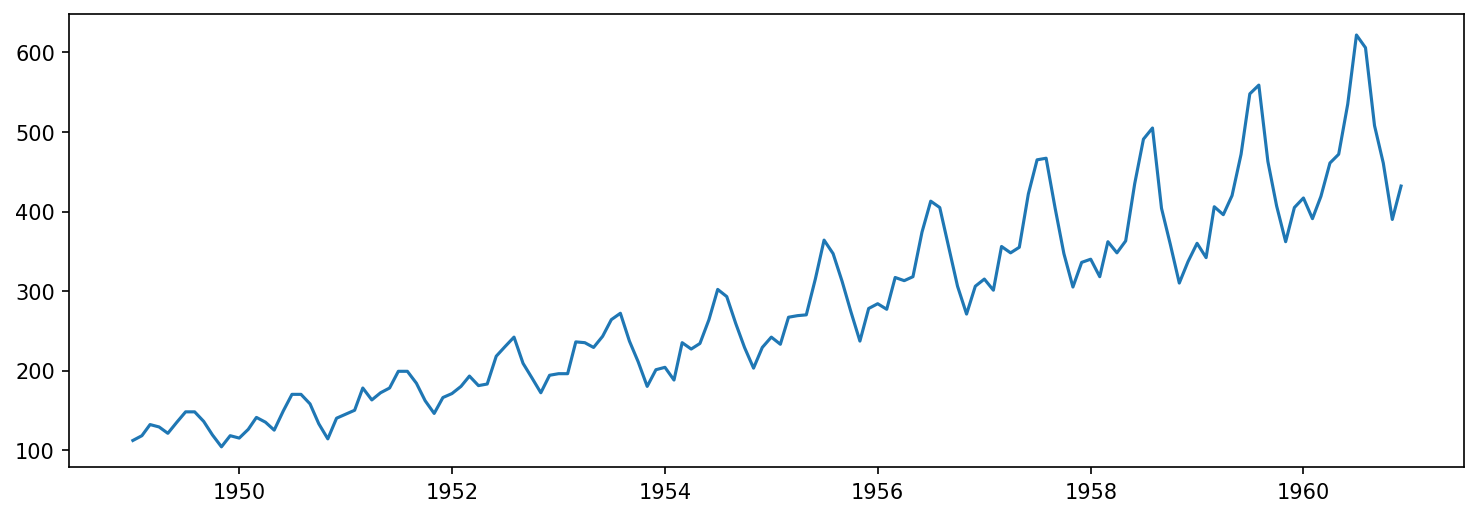

In [24]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(passengers["num_passengers"])
plt.show()

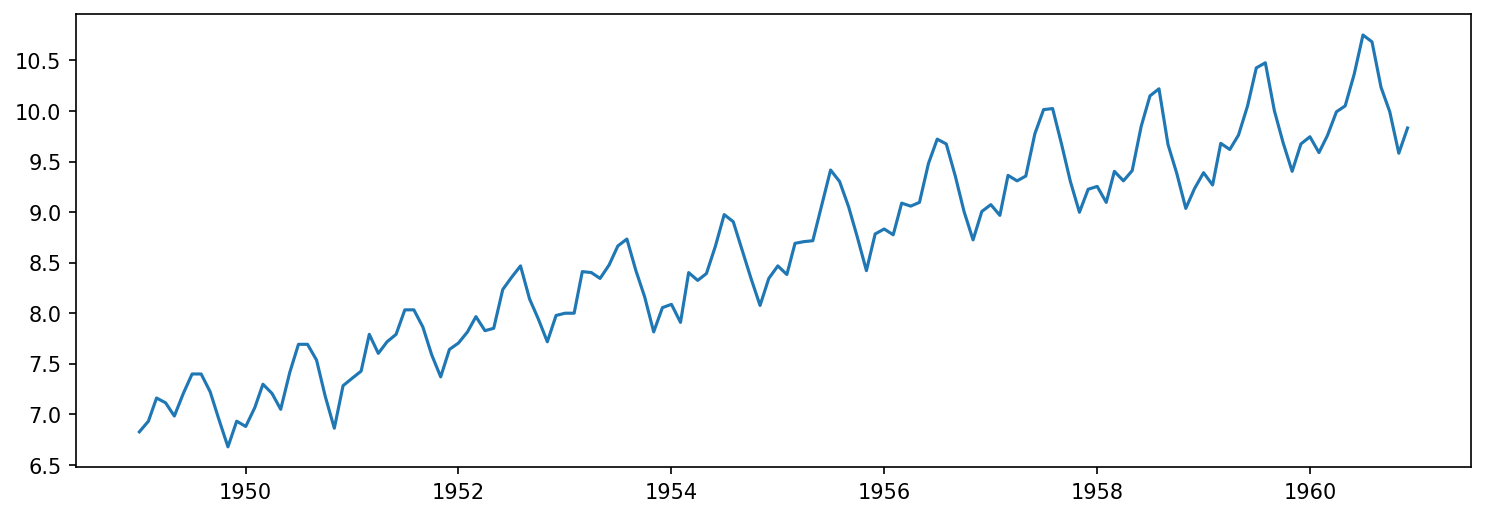

In [22]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(boxcox(passengers["num_passengers"], lambda_))
plt.show()